# Initialize

In [1]:
import os
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.3 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [2]:
import datetime

today = datetime.date.today().strftime('%y%m%d')

# Introduction

In this notebook, we pre-process scRNAseq data from Alzheimer's disease (AD) mice (Keren-Shaul et al., Cell, 2017, GEO accession code GSE98969). The dataset consists of several parts. We analyse the wild type samples (C57BL/6) and the AD mouse samples (5XFAD). We do not consider other KO samples.  

## Read data

Set project and data directory.

In [3]:
project_dir = './'
data_dir = './data/GSE98969_RAW/'

Read in the metadata (experimental design info).

In [4]:
metadata = pd.read_table('./data/GSE98969_experimental_design_f.txt', 
                         skiprows=17, index_col=0)

In [5]:
metadata.head()

,Seq_batch_ID,Amp_batch_ID,well_coordinates,Mouse_ID,plate_ID,Batch_desc,Pool_barcode,Cell_barcode,Spike_type,Number_of_cells
Well_ID,,,,,,,,,,
W308561,SB79,AB1442,A1,5XFAD,PHK0001,AD6m mouse1 plate#1,CTGA,CTATTCG,ERCC_mix1,1
W308562,SB79,AB1442,C1,5XFAD,PHK0001,AD6m mouse1 plate#1,CTGA,ACTCAGG,ERCC_mix1,1
W308563,SB79,AB1442,E1,5XFAD,PHK0001,AD6m mouse1 plate#1,CTGA,ACACGTG,ERCC_mix1,1
W308564,SB79,AB1442,G1,5XFAD,PHK0001,AD6m mouse1 plate#1,CTGA,TCTTCGA,ERCC_mix1,1
W308565,SB79,AB1442,I1,5XFAD,PHK0001,AD6m mouse1 plate#1,CTGA,AGCACTG,ERCC_mix1,1


Here's the info from the header of the experimental design file, that describes the meaning of each row.

|Field|Description|
|-|-|
|Well_ID|	well identifier|
|Seq_batch_ID|	Illumina suquencing batch ID|
|Amp_batch_ID|	amplification batch ID (of 192/384 single cells)|				
|well_coordinates|	location on 384 wells plates|
|Mouse_ID|	mouse type|
|Plate_ID|	sorting batch ID (384 wells plates)|
|Batch_desc|	Information of the experiment, sorting scheme and genetic background of mouse|
|Pool_barcode|	Pool barcode (may overlap between different sorting batches)|
|Cell_barcode|	Single cell barcode|
|Spike_type|	random molecular tag sequence|
|Number_of_cells|	Number of cells sorted to well (0/1)|

In [51]:
metadata.shape

(41856, 10)

Unzip all files in the data directory.

In [4]:
!gzip -d {data_dir}/* 

In [5]:
files = os.listdir(data_dir)

In [17]:
files[0]

'GSM2629363_AB1558.txt'

The data is stored as `txt` files, one for each plate.

In [32]:
adatas = []
for file_idx in files:
    if file_idx.endswith('.txt'):
        adata_tmp = sc.read_text(data_dir+ file_idx).T
        adatas.append(adata_tmp)


Concatenate `adatas` to one `anndata` file.

In [54]:
adata = ann.AnnData.concatenate(
    *adatas, 
    batch_key = 'batch',
    index_unique=None
).copy()

In [55]:
adata

AnnData object with n_obs × n_vars = 37248 × 34016
    obs: 'Amp_batch_ID', 'batch'

In [56]:
adata.obs_names

Index(['W345425', 'W345426', 'W345427', 'W345428', 'W345429', 'W345430',
       'W345431', 'W345432', 'W345433', 'W345434',
       ...
       'W624775', 'W624776', 'W624777', 'W624778', 'W624779', 'W624780',
       'W624781', 'W624782', 'W624783', 'W624784'],
      dtype='object', length=37248)

Merge `adata` with `metadata` file.

In [59]:
for keys in metadata.columns:
    adata.obs[keys] = metadata[keys]

In [60]:
adata.obs_keys()

['Amp_batch_ID',
 'batch',
 'Mouse_ID',
 'Seq_batch_ID',
 'well_coordinates',
 'plate_ID',
 'Batch_desc',
 'Pool_barcode',
 'Cell_barcode',
 'Spike_type',
 'Number_of_cells']

Check the data of the mice - this is what we want to compare.

In [63]:
adata.obs['Mouse_ID'].value_counts()

C57BL/6          16512
5XFAD            14208
SOD1              3072
Trem2KO_5XFAD     2304
Trem2KO           1152
Name: Mouse_ID, dtype: int64

Additional information on the mice, e.g. age, is to be extracted from the `Batch description`.

In [77]:
adata.obs['Batch_desc'].value_counts()

ALS_control1_d135_plate#1                                                    693
ALS_mouse1_d135_plate#1                                                      664
old_20m_mouse2_plate#2                                                       561
Trem2_KO_AD_cd11c_plate#1                                                    380
WT6m_mouse3_plate#2                                                          378
                                                                            ... 
AD9m_mouse1_plate#1                                                          173
AD6m mouse2 plate#1 (first 4 lines), WT6m mouse2 plate#2 (rest of plate).    111
WT6m mouse2 plate#1                                                          106
ALS_mouse4_d80_plate#1                                                        67
ALS_mouse1_d80_plate#1                                                        59
Name: Batch_desc, Length: 94, dtype: int64

Write concatenated data to file.

In [64]:
adata.write(project_dir + 'data/' +'GSE98969_adata.h5ad')

... storing 'Amp_batch_ID' as categorical
... storing 'Mouse_ID' as categorical
... storing 'Seq_batch_ID' as categorical
... storing 'well_coordinates' as categorical
... storing 'plate_ID' as categorical
... storing 'Batch_desc' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Spike_type' as categorical


In [178]:
adata = sc.read(project_dir + 'data/' +'GSE98969_adata.h5ad')

## Additional metadata

Let us extract the additional information on the mice (e.g. age) from the `Batch_desc` column.

In [179]:
tmp_meta = adata.obs['Batch_desc']

In [180]:
tmp_meta_list = [idx.split(' ') for idx in tmp_meta]

In [181]:
list_len = list()
for idx in enumerate(tmp_meta_list):
    tmp_meta_list[idx[0]] = np.concatenate([idx[1][0].split('_'), idx[1][1:]])
    list_len.append(len(tmp_meta_list[idx[0]]))

Check `list_len` stats.

In [182]:
pd.value_counts(list_len)

4     18432
3     17280
5      1152
12      384
dtype: int64

This listing is rough, but sufficient to describe the data.

In [183]:
mouse_type = [idx[0] for idx in tmp_meta_list]
second_entry = [idx[1] for idx in tmp_meta_list]
third_entry = [idx[2] for idx in tmp_meta_list]
plate_id = [idx[-1] for idx in tmp_meta_list]

In [184]:
remainder_type = list()
for idx in enumerate(tmp_meta_list):
    if len(idx[1])>3 and len(idx[1])<10:
        #if idx[3].startswith('plate'):   
        remainder_type.append(' '.join(idx[1][3:]))  
    elif len(idx[1])>9:
        remainder_type.append(' '.join(idx[1]))  
    else:
        remainder_type.append('None')  

In [185]:
pd.value_counts(mouse_type)

AD6m     11520
WT6m      9600
ALS       5760
Trem2     5376
young     1152
old       1152
AD1m       768
AD9m       384
AD3m       384
WT1m       384
WT3m       384
WT8m       384
dtype: int64

In [186]:
pd.value_counts(second_entry)

mouse2        6528
mouse1        6528
mouse3        5376
cerebellum    3840
cortex        3840
KO            3456
control1      1536
20m           1152
AD            1152
7w            1152
mouse4         768
WT             768
control2       768
control3       384
dtype: int64

In [187]:
pd.value_counts(third_entry)

plate#1    6144
mouse2     5376
mouse1     4608
d80        4224
plate#2    3456
plate#3    2688
plate#4    2304
AD         2304
d135       1536
plate#6    1536
cd11c      1536
plate#5    1536
dtype: int64

In [188]:
pd.value_counts(plate_id)

plate#1    16128
plate#2    10368
plate#3     4992
plate#4     2304
plate#6     1536
plate#5     1536
plate).      384
dtype: int64

In [189]:
pd.value_counts(remainder_type)

None                                                                         17280
plate#1                                                                       9984
plate#2                                                                       6528
plate#3                                                                       1920
AD6m mouse2 plate#1 (first 4 lines), WT6m mouse2 plate#2 (rest of plate).      384
cd11c plate#3                                                                  384
cd11c plate#1                                                                  384
cd11c plate#2                                                                  384
dtype: int64

Extract experiment type and age information.

In [190]:
types = list()
age = list()
for value in enumerate(mouse_type):
    if value[1].startswith('AD'):
        types.append('AD')
        age.append(value[1][2:])
    elif value[1].startswith('WT'):
        types.append('WT')
        age.append(value[1][2:])
    elif np.logical_or(value[1].startswith('young'), value[1].startswith('old')):
        types.append(value[1])
        age.append(second_entry[value[0]])
    else:
        types.append(value[1])
        age.append('unknown')

In [191]:
pd.value_counts(types)

AD       13056
WT       10752
ALS       5760
Trem2     5376
young     1152
old       1152
dtype: int64

In [192]:
pd.value_counts(age)

6m         21120
unknown    11136
20m         1152
1m          1152
7w          1152
3m           768
9m           384
8m           384
dtype: int64

In [193]:
adata.obs['mouse_type'] = types
adata.obs['age'] = age

In [194]:
adata.obs['plate_id'] = plate_id
adata.obs['plate_id'].loc[adata.obs['plate_id']=='plate).'] = 'mixed'

/Users/maren.buettner/anaconda3/envs/cr-rpy2/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Next, we extract the information on the location (cortex or cerebellum).

In [195]:
pd.value_counts(second_entry)

mouse2        6528
mouse1        6528
mouse3        5376
cerebellum    3840
cortex        3840
KO            3456
control1      1536
20m           1152
AD            1152
7w            1152
mouse4         768
WT             768
control2       768
control3       384
dtype: int64

Check if the mouse id is present in the description of the region sorted cells.

In [196]:
test_ids = list()
for idx in np.flatnonzero(np.in1d(second_entry, ['cerebellum','cortex'])):
    test_ids.append(third_entry[idx])

In [197]:
pd.value_counts(test_ids)

mouse1    3840
mouse2    3840
dtype: int64

Create lists for the biological replicate and the location.

In [198]:
replicate = list()
location = list()
for value in enumerate(second_entry):
    if value[1].startswith('cerebellum') and third_entry[value[0]].startswith('mouse'):
        location.append('cerebellum')
        replicate.append(third_entry[value[0]])
    elif value[1].startswith('cortex') and third_entry[value[0]].startswith('mouse'):
        location.append('cortex')
        replicate.append(third_entry[value[0]])
    elif value[1].startswith('mouse'):
        location.append('unknown')
        replicate.append(value[1])
    elif third_entry[value[0]].startswith('mouse') and not value[1].startswith('mouse'):    
        location.append('unknown')
        replicate.append(third_entry[value[0]])
    else:
        location.append('unknown')
        replicate.append(value[1])

In [176]:
pd.value_counts(replicate)

mouse2      11904
mouse1      11136
mouse3       5376
KO           3456
control1     1536
AD           1152
mouse4        768
WT            768
control2      768
control3      384
dtype: int64

In [199]:
pd.value_counts(location)

unknown       29568
cerebellum     3840
cortex         3840
dtype: int64

In [200]:
adata.obs['location'] = location
adata.obs['replicate'] = replicate

For the mixed well plate, we have to assign the cells to either AD or WT depending on their location in the 384 well plate. According to the `Batch description`. The first four 4 lines were AD cells while the rest of the plate were WT cells. 

The design of the 384 well plate labels rows with letters and columns with digits. We assume that 'lines' is the same as 'rows' in this context. Therefore, we assign the 'AD' label to all cells from rows A-D and 'WT' to all others. The age label is already assigned as '6m'.

In [201]:
mixed_id = np.flatnonzero(adata.obs['plate_id']=='mixed')
letters = [idx[0] for idx in adata.obs['well_coordinates']]
for idx in mixed_id:
    if np.in1d(letters[idx], ['A', 'B', 'C', 'D']):
        adata.obs['mouse_type'][idx] ='AD'
        adata.obs['plate_id'][idx] = remainder_type[idx].split(' ')[2]
    else:
        adata.obs['mouse_type'][idx] ='WT'
        adata.obs['plate_id'][idx] = remainder_type[idx].split(' ')[8]

<ipython-input-201-168717bd3780>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['mouse_type'][idx] ='AD'
<ipython-input-201-168717bd3780>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['plate_id'][idx] = remainder_type[idx].split(' ')[2]
<ipython-input-201-168717bd3780>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['mouse_type'][idx] ='WT'
<ipython-input-201-168717bd3780>:9: SettingWithCopyWarning: 

# Quality control and filtering

In this section, we check whether we have to apply some filtering to the data.

Let us compute the key metrics for quality control. Please note that this computation contains ERCCs, too.

In [202]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

/Users/maren.buettner/anaconda3/envs/cr-rpy2/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:399: RuntimeWarning: invalid value encountered in true_divide
  return values / sums[:, None]


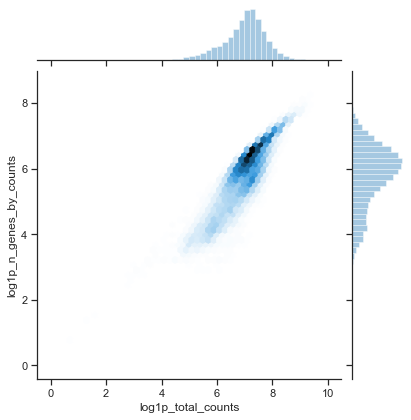

In [203]:
sb.jointplot(
        "log1p_total_counts", "log1p_n_genes_by_counts",
        data=adata.obs, kind="hex"
    )

... storing 'mouse_type' as categorical
... storing 'age' as categorical
... storing 'plate_id' as categorical
... storing 'location' as categorical
... storing 'replicate' as categorical


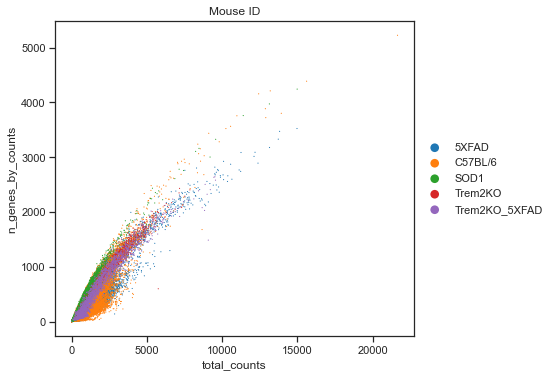

In [204]:
rcParams['figure.figsize']=(6,6)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='Mouse_ID', size=5)

Next, we filter out all genes with less than 1 count per cell.

In [205]:
sc.pp.filter_genes(adata, min_counts=1)

filtered out 11065 genes that are detected in less than 1 counts


Remove ERCCs in addition.

In [206]:
ercc_mask = [gene for gene in adata.var_names if gene.startswith('ERCC')]

In [207]:
adata = adata[:,np.invert(np.in1d(adata.var_names, ercc_mask))]

According to the publication, the authors filtered out all cells with less than 500 UMIs/cell.

In [208]:
sc.pp.filter_cells(adata, min_counts=500)

filtered out 12053 cells that have less than 500 counts


Trying to set attribute `.obs` of view, copying.


According to the publication, no further filtering steps were undertaken.

In [209]:
adata

AnnData object with n_obs × n_vars = 25195 × 22860
    obs: 'Amp_batch_ID', 'batch', 'Mouse_ID', 'Seq_batch_ID', 'well_coordinates', 'plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'Spike_type', 'Number_of_cells', 'mouse_type', 'age', 'plate_id', 'location', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'Mouse_ID_colors'

# Normalisation and first visualisation

According to the publication, no further normalisation or batch effect correction was used, which I find surprising. From what I gathered in the data description, they used a logCPM normalisation. We use the logCPM normalisation in the following.

In [210]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Compute embedding.

In [126]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)

computing PCA
    with n_comps=50
    finished (0:00:50)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [127]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


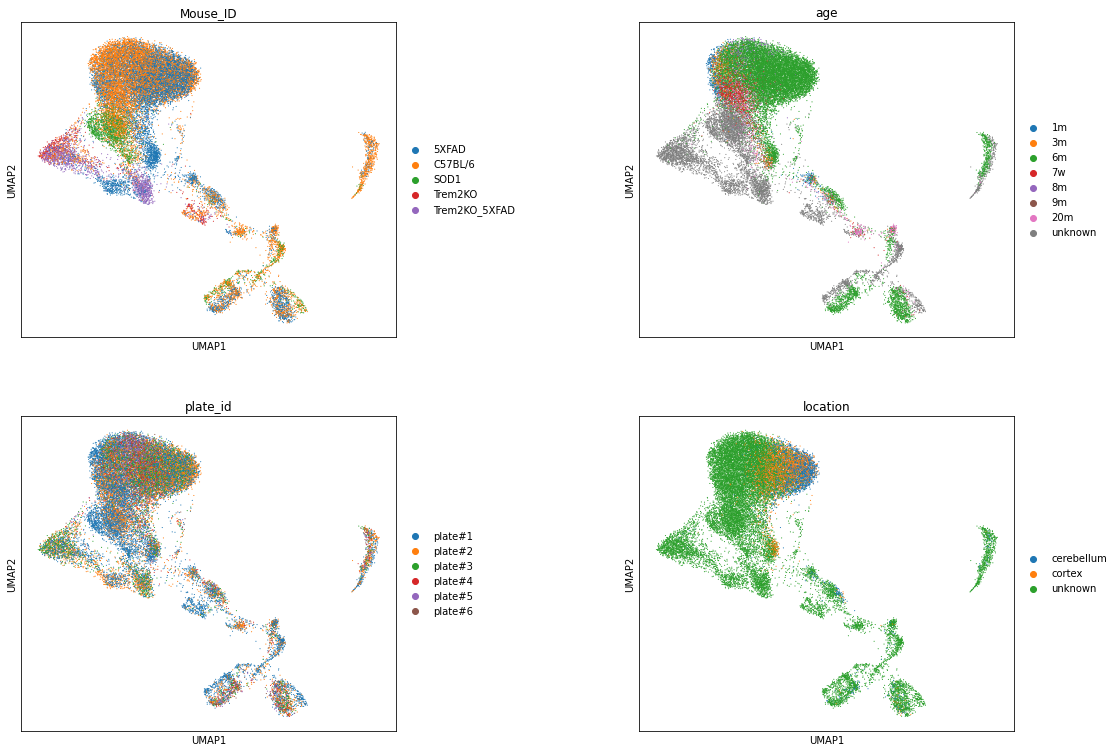

In [128]:
sc.pl.umap(adata, color=['Mouse_ID', 'age', 'plate_id', 'location'], ncols=2, wspace=0.5)

# Analyse 5XFAD and C57BL/6 mice 

Let us restrict the dataset to the AD mice (5XFAD) and the control mice (C57BL/6).

In [211]:
adata_AD = adata[np.in1d(adata.obs['Mouse_ID'], ['5XFAD', 'C57BL/6'])].copy()

In [212]:
adata_AD

AnnData object with n_obs × n_vars = 21245 × 22860
    obs: 'Amp_batch_ID', 'batch', 'Mouse_ID', 'Seq_batch_ID', 'well_coordinates', 'plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'Spike_type', 'Number_of_cells', 'mouse_type', 'age', 'plate_id', 'location', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'Mouse_ID_colors', 'log1p'

In [213]:
pd.crosstab(adata_AD.obs['Mouse_ID'], adata_AD.obs['mouse_type'])

mouse_type,AD,ALS,Trem2,WT,old,young
Mouse_ID,,,,,,
5XFAD,8647,0,659,83,0,0
C57BL/6,0,1981,418,7733,755,969


In [214]:
pd.crosstab(adata_AD.obs['age'], adata_AD.obs['mouse_type'])

mouse_type,AD,ALS,Trem2,WT,old,young
age,,,,,,
1m,506,0,0,333,0,0
3m,180,0,0,315,0,0
6m,7818,0,0,6829,0,0
7w,0,0,0,0,0,969
8m,0,0,0,339,0,0
9m,143,0,0,0,0,0
20m,0,0,0,0,755,0
unknown,0,1981,1077,0,0,0


Select the 6m old AD and WT cells.

In [215]:
adata_6m = adata_AD[adata_AD.obs['age']=='6m'].copy()

Remove cells where the location is known to annotate the cells. We transfer the annotation to the second set of cells where the location is known.

In [216]:
adata_6m = adata_6m[adata_6m.obs['location']=='unknown']

In [217]:
adata_6m

View of AnnData object with n_obs × n_vars = 9196 × 22860
    obs: 'Amp_batch_ID', 'batch', 'Mouse_ID', 'Seq_batch_ID', 'well_coordinates', 'plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'Spike_type', 'Number_of_cells', 'mouse_type', 'age', 'plate_id', 'location', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'Mouse_ID_colors', 'log1p'

In [218]:
adata_6m.obs['location'].value_counts()

unknown    9196
Name: location, dtype: int64

In [219]:
adata_6m.obs['plate_id'].value_counts()

plate#1    2176
plate#2    1744
plate#4    1743
plate#3    1556
plate#6    1044
plate#5     933
Name: plate_id, dtype: int64

We somehow end up with about 1,000 cells more than the original publication (which reported 8,016 cells).

Compute embedding.

In [220]:
sc.pp.pca(adata_6m)
sc.pp.neighbors(adata_6m)
sc.tl.umap(adata_6m)

computing PCA
    with n_comps=50
    finished (0:00:23)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


Cluster the data.

In [221]:
sc.tl.louvain(adata_6m, resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


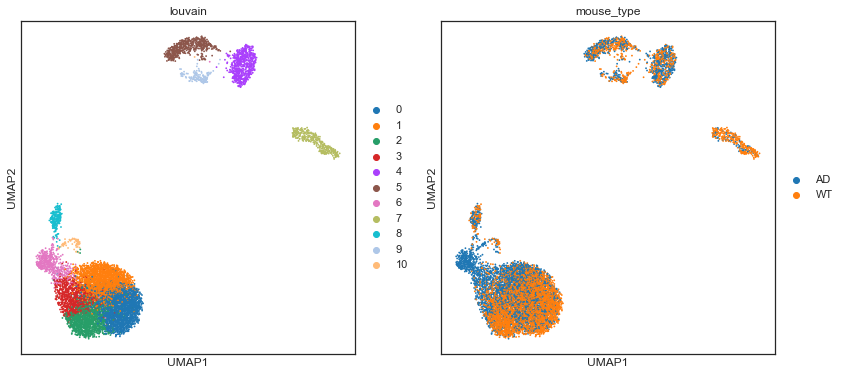

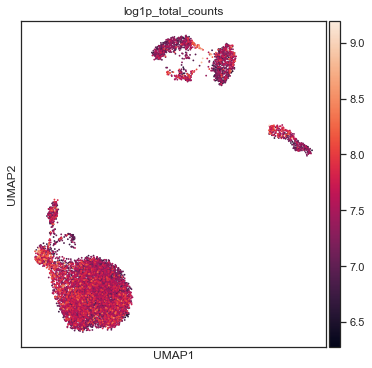

In [222]:
sc.pl.umap(adata_6m, color=['louvain', 'mouse_type'])
sc.pl.umap(adata_6m, color=['log1p_total_counts'])

# Annotate clusters

Characterise the clusters first by running the `rank_genes_groups` differential expression test and examine the top 20 differentially expressed genes.

In [223]:
sc.tl.rank_genes_groups(adata_6m, groupby='louvain')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


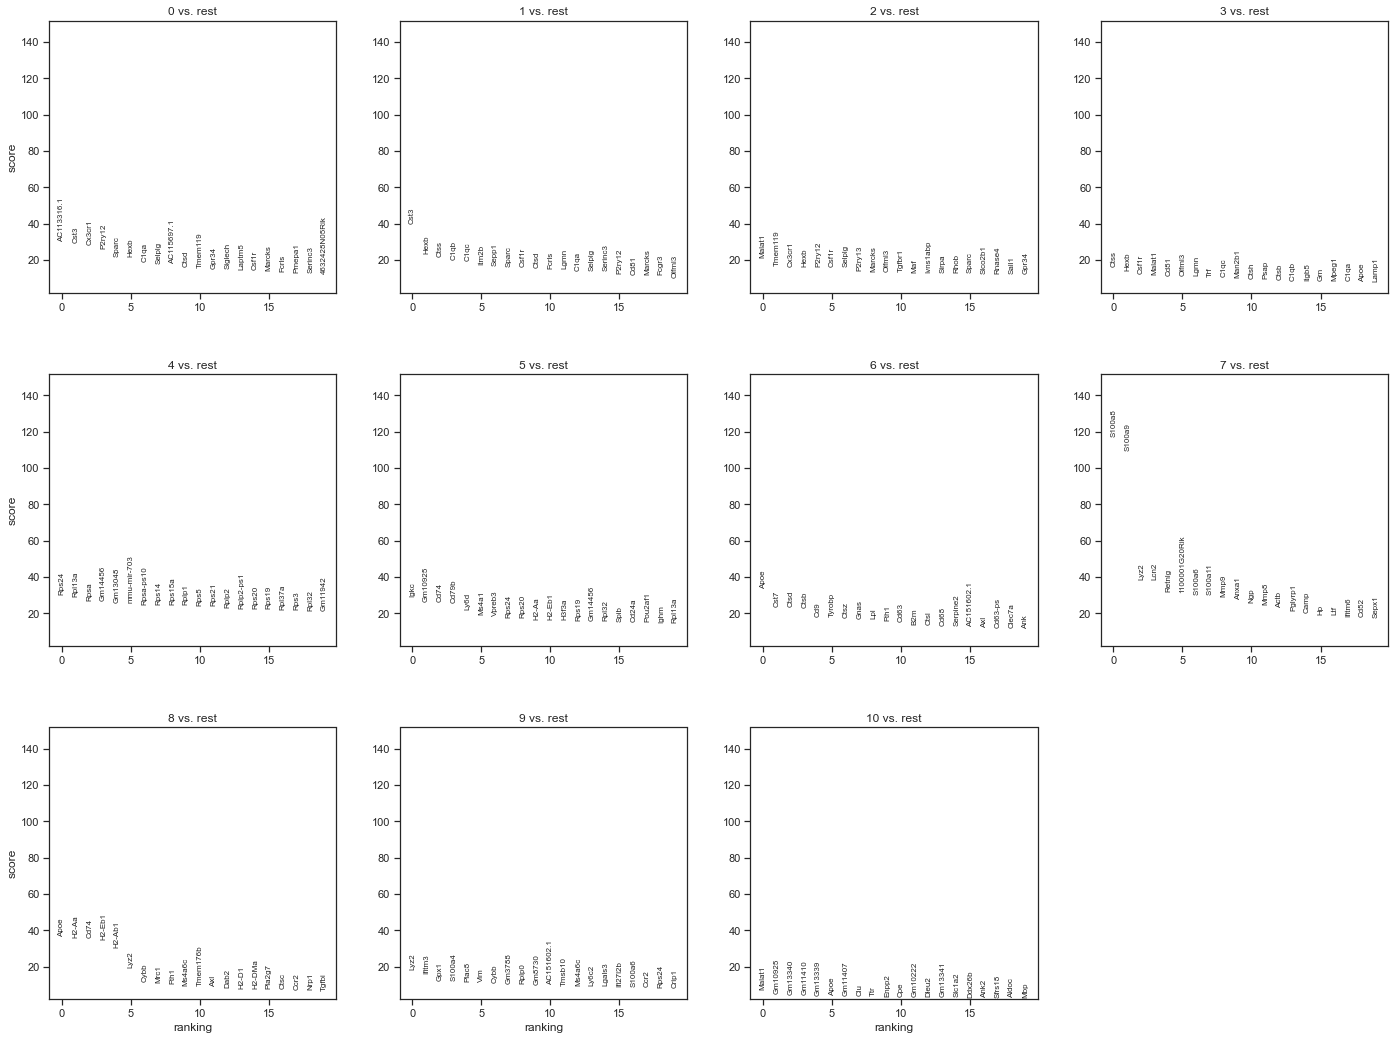

In [224]:
sc.pl.rank_genes_groups(adata_6m)

We remove cluster 10 because it does not show any relevant gene expression.

In [225]:
adata_6m = adata_6m[np.invert(adata_6m.obs['louvain']=='10')]

Let us plot the marker genes (see Figure 1B of Keren-Shaul et al.).

In [51]:
marker_genes = {'granulocytes' : ['Camp', 'S100a9'], 
                'T/NK cells' :['S100a4', 'Nkg7','Trbc2'], 
                 'B cells' : ['Rag1', 'Cd79b', 'Cd74'],
                'monocytes' : ['S100a4', 'Cd74'],
                'perivascular macrophages' : [ 'Cd74','Cd163', 'Mrc1'],
                'microglia 2-3' : ['Lpl', 'Cst7'], 
                'microglia 1' : ['Ctsd', 'Cd9', 'Hexb', 'Cst3']}

In [227]:
marker_genes

{'granulocytes': ['Camp', 'S100a9'],
 'T/NK cells': ['S100a4', 'Nkg7', 'Trbc2'],
 'B cells': ['Rag1', 'Cd79b', 'Cd74'],
 'monocytes': ['S100a4', 'Cd74'],
 'perivascular macrophages': ['Cd74', 'Cd163', 'Mrc1'],
 'microglia 2-3': ['Lpl', 'Cst7'],
 'microglia 1': ['Ctsd', 'Cd9', 'Hexb', 'Cst3']}

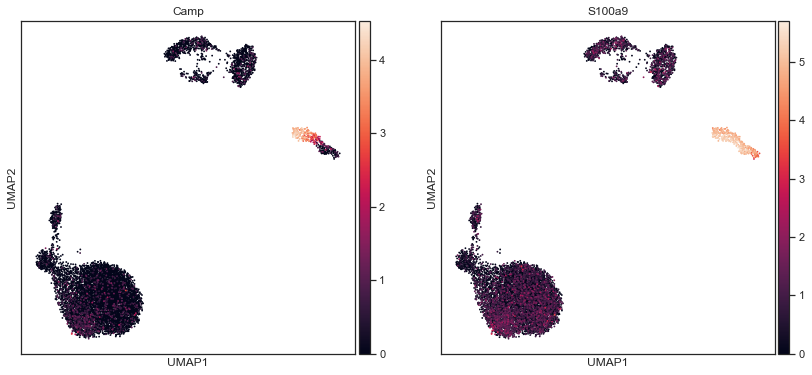

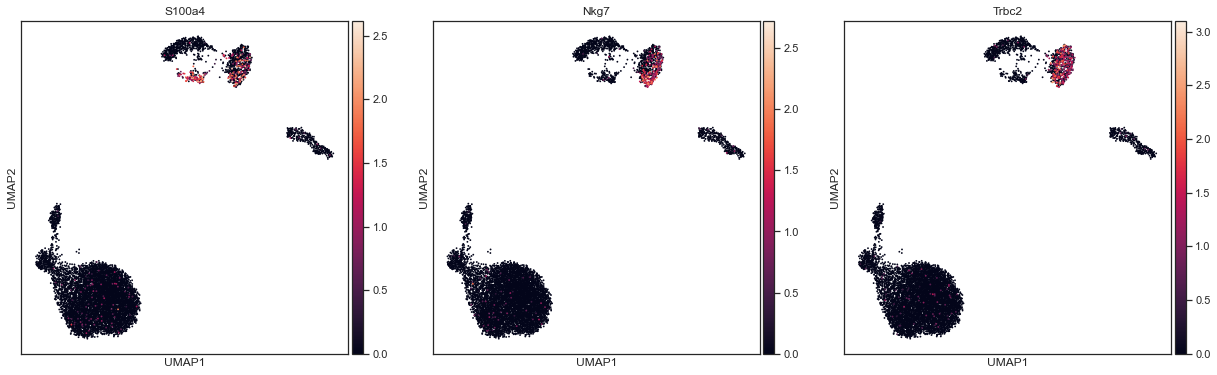

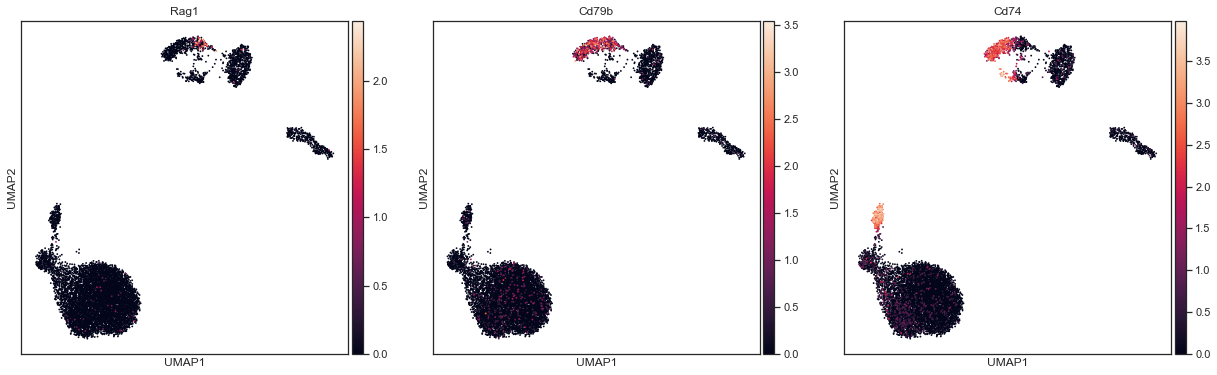

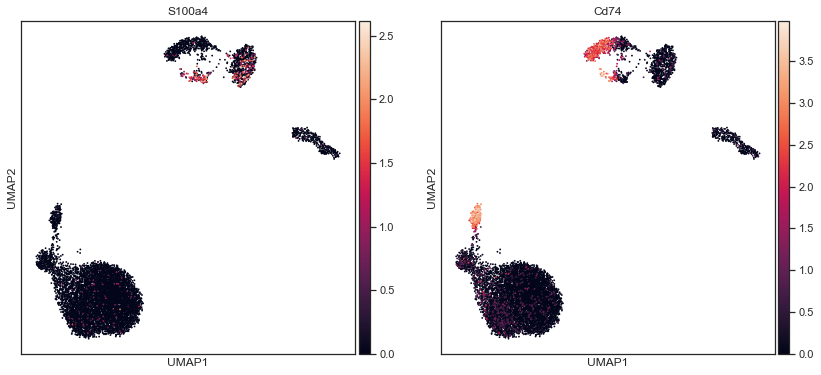

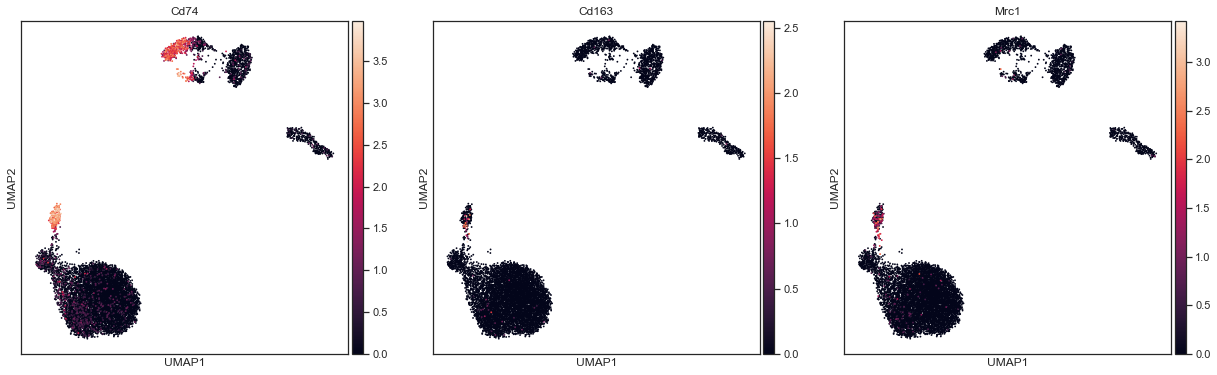

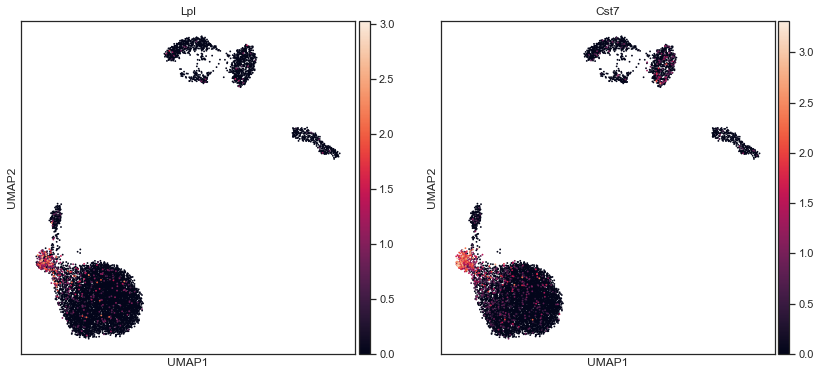

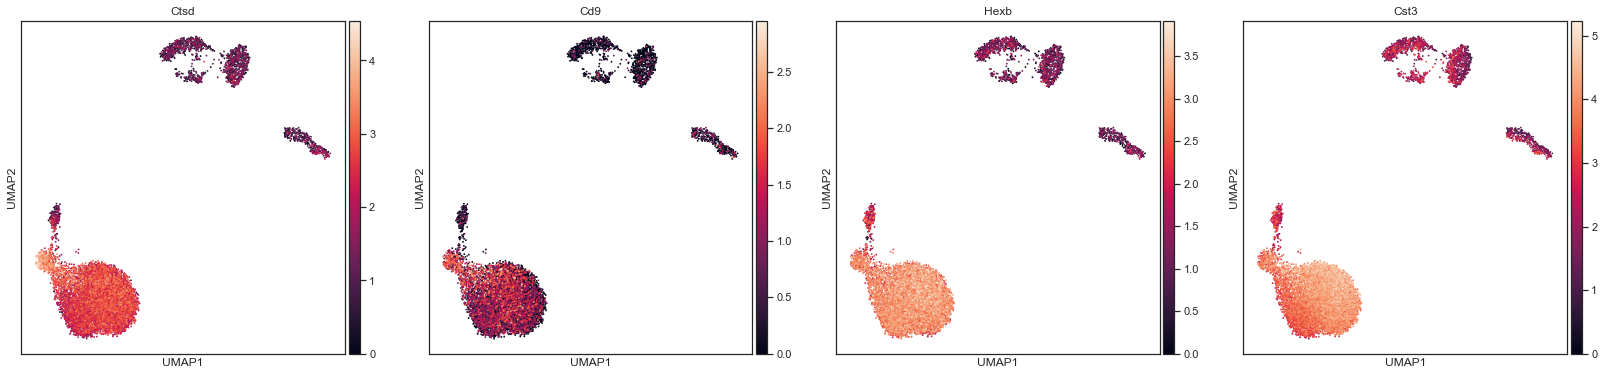

In [228]:
for key in marker_genes.keys():
    sc.pl.umap(adata_6m, color=marker_genes[key], ncols=4)

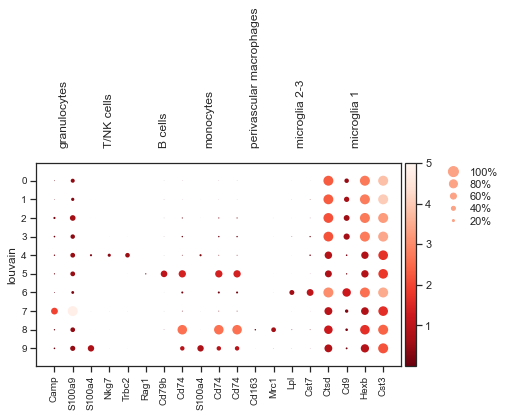

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.6499999999999995, 0, 0.2, 0.5, 0.25])

In [229]:
sc.pl.dotplot(adata_6m, groupby='louvain', var_names=marker_genes, color_map='Reds_r', vmax=5)

In [230]:
adata_6m.obs['cell types'] = adata_6m.obs['louvain'].cat.add_categories(['granulocytes', 'T/NK cells',
 'B cells', 'monocytes', 'perivascular macrophages', 'microglia'])

adata_6m.obs['cell types'][np.in1d(adata_6m.obs['louvain'], ['0','1','2','3','6'])] = 'microglia'
adata_6m.obs['cell types'][np.in1d(adata_6m.obs['louvain'], ['7'])] = 'granulocytes'
adata_6m.obs['cell types'][np.in1d(adata_6m.obs['louvain'], ['4'])] = 'T/NK cells'
adata_6m.obs['cell types'][np.in1d(adata_6m.obs['louvain'], ['5'])] = 'B cells'
adata_6m.obs['cell types'][np.in1d(adata_6m.obs['louvain'], ['8'])] = 'perivascular macrophages'
adata_6m.obs['cell types'][np.in1d(adata_6m.obs['louvain'], ['9'])] = 'monocytes'
adata_6m.obs['cell types'] = adata_6m.obs['cell types'].cat.remove_unused_categories()

Trying to set attribute `.obs` of view, copying.


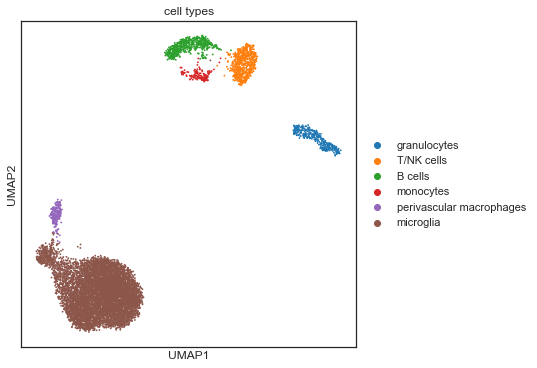

In [231]:
sc.pl.umap(adata_6m, color='cell types')

## Find subclusters in microglia population

Let us subcluster the microglia population.

In [232]:
sc.tl.louvain(adata_6m, restrict_to=['cell types', ['microglia']], resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:01)


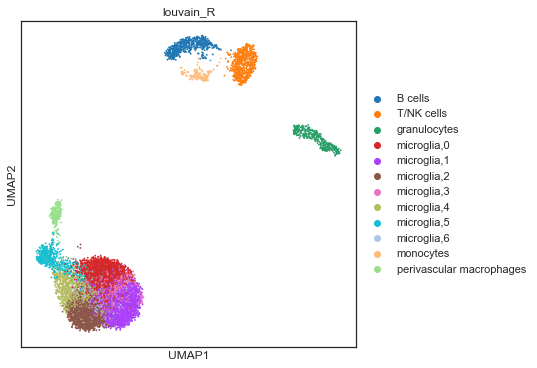

In [233]:
sc.pl.umap(adata_6m, color='louvain_R')

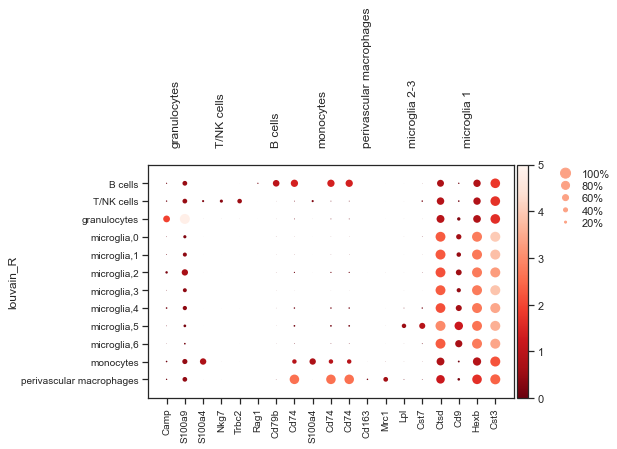

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.6499999999999995, 0, 0.2, 0.5, 0.25])

In [234]:
sc.pl.dotplot(adata_6m, groupby='louvain_R', var_names=marker_genes, color_map='Reds_r', vmax=5)

Based on the marker expression of `Cst7` and `Lpl`, we think that `microglia, 4` and `microglia, 5` contain the `microglia 2` and `microglia 3` populations. The remaining microglia are renamed to `microglia 1`. We run another round of subclustering the populations `microglia, 4` and `microglia, 5`.

In [394]:
sc.tl.louvain(adata_6m, restrict_to=['louvain_R', ['microglia,4', 'microglia,5']], resolution=1.5, 
              key_added='microglia_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'microglia_sub', the cluster labels (adata.obs, categorical) (0:00:00)


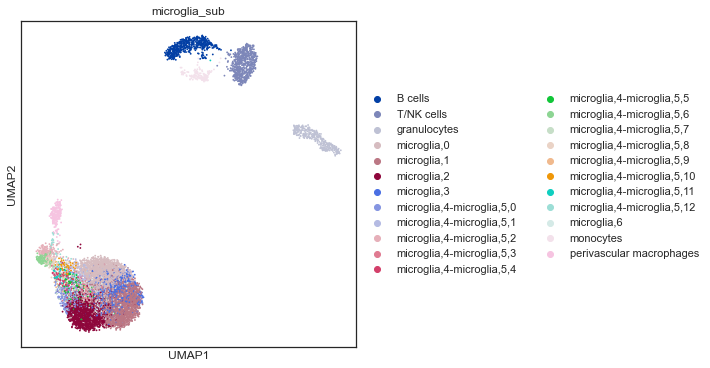

In [395]:
sc.pl.umap(adata_6m, color='microglia_sub')

In [396]:
adata_6m.obs['microglia_sub'].cat.categories

Index(['B cells', 'T/NK cells', 'granulocytes', 'microglia,0', 'microglia,1',
       'microglia,2', 'microglia,3', 'microglia,4-microglia,5,0',
       'microglia,4-microglia,5,1', 'microglia,4-microglia,5,2',
       'microglia,4-microglia,5,3', 'microglia,4-microglia,5,4',
       'microglia,4-microglia,5,5', 'microglia,4-microglia,5,6',
       'microglia,4-microglia,5,7', 'microglia,4-microglia,5,8',
       'microglia,4-microglia,5,9', 'microglia,4-microglia,5,10',
       'microglia,4-microglia,5,11', 'microglia,4-microglia,5,12',
       'microglia,6', 'monocytes', 'perivascular macrophages'],
      dtype='object')

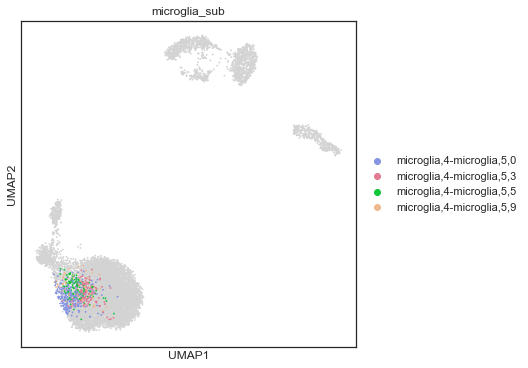

In [403]:
sc.pl.umap(adata_6m, color='microglia_sub', groups=['microglia,4-microglia,5,0',
                                                   'microglia,4-microglia,5,3',
                                                   'microglia,4-microglia,5,5',
                                                   'microglia,4-microglia,5,9'])

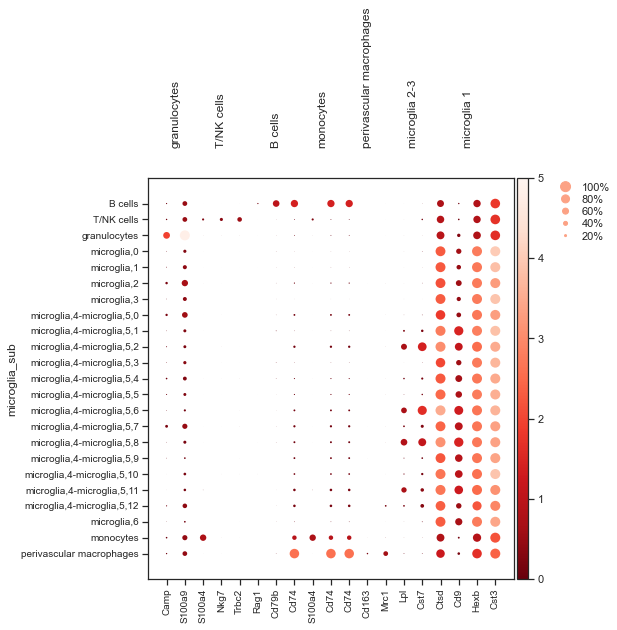

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.6499999999999995, 0, 0.2, 0.5, 0.25])

In [398]:
sc.pl.dotplot(adata_6m, groupby='microglia_sub', var_names=marker_genes, color_map='Reds_r', vmax=5)

Subclustering reveals a split into several populations. 

- 'microglia,4-microglia,5,0', 'microglia,4-microglia,5,3', 'microglia,4-microglia,5,5', 'microglia,4-microglia,5,9' are `microglia 1` 
- 'microglia,4-microglia,5,12' is a 'perivascular Mf'
- 'microglia,4-microglia,5,2', 'microglia,4-microglia,5,6', 'microglia,4-microglia,5,8' are `microglia 3`
- 'microglia,4-microglia,5,1', 'microglia,4-microglia,5,4', 'microglia,4-microglia,5,7', 'microglia,4-microglia,5,10', 'microglia,4-microglia,5,11' are `microglia 2`

In [405]:
adata_6m.obs['cell types refined'] = adata_6m.obs['cell types'].cat.add_categories(['microglia 1', 
                                                                                    'microglia 2', 'microglia 3'])

adata_6m.obs['cell types refined'][np.in1d(adata_6m.obs['cell types'], ['microglia'])] = 'microglia 1'
adata_6m.obs['cell types refined'][np.in1d(adata_6m.obs['microglia_sub'], 
                                           ['microglia,4-microglia,5,1', 'microglia,4-microglia,5,4', 
                                            'microglia,4-microglia,5,7', 'microglia,4-microglia,5,10', 
                                            'microglia,4-microglia,5,11'])] = 'microglia 2'
adata_6m.obs['cell types refined'][np.in1d(adata_6m.obs['microglia_sub'],
                                           ['microglia,4-microglia,5,2', 'microglia,4-microglia,5,6', 
                                            'microglia,4-microglia,5,8'])] = 'microglia 3'
adata_6m.obs['cell types refined'][np.in1d(adata_6m.obs['microglia_sub'], 
                                           ['microglia,4-microglia,5,12'])] = 'perivascular macrophages'
adata_6m.obs['cell types refined'] = adata_6m.obs['cell types refined'].cat.remove_unused_categories()

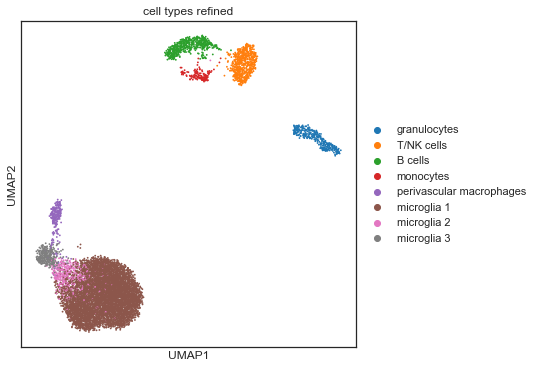

In [406]:
sc.pl.umap(adata_6m, color='cell types refined')

In [407]:
tmp = adata_6m.obs.groupby(['mouse_type', 'replicate', 
                    'cell types refined'])['replicate'].count().unstack().fillna(0)
tmp = tmp.rename(columns=str).reset_index()

In [408]:
tmp.columns

Index(['mouse_type', 'replicate', 'granulocytes', 'T/NK cells', 'B cells',
       'monocytes', 'perivascular macrophages', 'microglia 1', 'microglia 2',
       'microglia 3'],
      dtype='object', name='cell types refined')

In [409]:
tmp = tmp.drop(['granulocytes', 'T/NK cells', 'B cells', 'monocytes',
                  'perivascular macrophages'], axis=1)

Drop last (empty) row.

In [410]:
tmp = tmp[:-1]

In [411]:
tmp

cell types refined,mouse_type,replicate,microglia 1,microglia 2,microglia 3
0,AD,mouse1,602,93,34
1,AD,mouse2,1066,118,112
2,AD,mouse3,931,101,108
3,AD,mouse4,76,39,71
4,WT,mouse1,815,16,1
5,WT,mouse2,1574,50,1
6,WT,mouse3,1371,42,0


Drop mouse 4 due to low cell number.

In [430]:
tmp = tmp.drop(3,axis=0)

In [431]:
tmp

cell types refined,mouse_type,replicate,microglia 1,microglia 2,microglia 3
0,AD,mouse1,602,93,34
1,AD,mouse2,1066,118,112
2,AD,mouse3,931,101,108
4,WT,mouse1,815,16,1
5,WT,mouse2,1574,50,1
6,WT,mouse3,1371,42,0


Get proportions.

In [432]:
tmp2 = tmp.loc[:, tmp.columns[2:]]
tmp2 = tmp2.div(tmp2.sum(axis=1), axis=0)*100

In [433]:
tmp2

cell types refined,microglia 1,microglia 2,microglia 3
0,82.578875,12.757202,4.663923
1,82.253086,9.104938,8.641975
2,81.666667,8.859649,9.473684
4,97.956731,1.923077,0.120192
5,96.861538,3.076923,0.061538
6,97.027601,2.972399,0.000000


In [434]:
tmp2[['mouse_type', 'replicate']] = tmp[['mouse_type', 'replicate']]

Text(0.5, 0, 'Cell type')

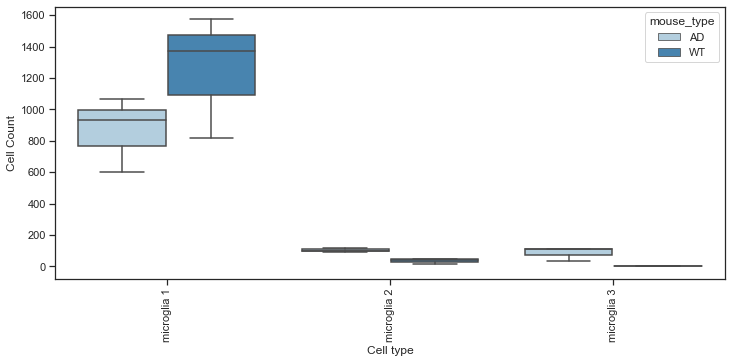

In [435]:
fig, ax = pl.subplots(figsize=(12,5))
df = pd.melt(tmp, id_vars=['mouse_type'], value_vars=tmp.columns[2:])
df['cell types refined'] = df['cell types refined'].astype('category')

df['mouse_type'] = df['mouse_type'].astype('category')
df['mouse_type'] = df['mouse_type'].cat.reorder_categories(['AD', 'WT'])

sb.set_context('notebook')
sb.set_style('ticks')
d = sb.boxplot(x='cell types refined', y = 'value', hue=df["mouse_type"], data=df, fliersize=1,
               palette='Blues')

d.set_ylabel('Cell Count')
loc, labels = pl.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')

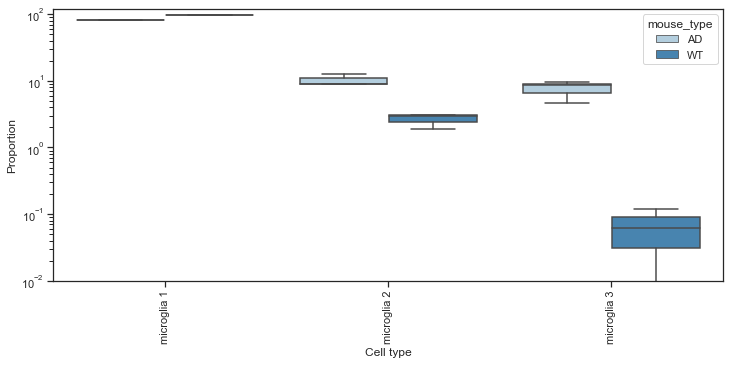

In [439]:
fig, ax = pl.subplots(figsize=(12,5))
df = pd.melt(tmp2, id_vars=['mouse_type'], value_vars=tmp.columns[2:])
df['cell types refined'] = df['cell types refined'].astype('category')

df['mouse_type'] = df['mouse_type'].astype('category')
df['mouse_type'] = df['mouse_type'].cat.reorder_categories(['AD', 'WT'])

sb.set_context('notebook')
sb.set_style('ticks')
d = sb.boxplot(x='cell types refined', y = 'value', hue=df["mouse_type"], data=df, fliersize=1,
               palette='Blues')

d.set_ylabel('Proportion')
d.set_yscale('log')
loc, labels = pl.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
d.set_ylim([0.01,120])
pl.savefig('./Microglia_boxplot.pdf', bbox_inches = 'tight')
pl.show()

According to Keren-Shaul et al., the microglia 3 population is a disease-associated microglia (DAM), that is specific for the Alzheimer's disease. In their publication, they projected location-sorted data of AD and WT mice onto the tSNE and assigned cell type labels. 
Here, use a knn-classifier instead, i.e. we add the location-labelled data to the annotated anndata object, recompute the neighbors and assign the cell type label via majority vote.

## Include data from cortex and cerebellum

In [418]:
adata_location = adata_AD[np.logical_and(adata_AD.obs['age']=='6m', 
                                         np.invert(adata_AD.obs['location']=='unknown'))].copy()

In [419]:
pd.crosstab(adata_location.obs['location'], adata_location.obs['mouse_type'])

mouse_type,AD,WT
location,,
cerebellum,1613,965
cortex,1869,1004


In [420]:
pd.crosstab(adata_location.obs['location'], adata_location.obs['replicate'])

replicate,mouse1,mouse2
location,,
cerebellum,1308,1270
cortex,1353,1520


In [421]:
adata_merge = adata_6m.concatenate(adata_location, index_unique=None)

Recompute embedding.

In [422]:
sc.pp.pca(adata_merge)
sc.pp.neighbors(adata_merge)

computing PCA
    with n_comps=50
    finished (0:00:32)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [423]:
sc.tl.umap(adata_merge)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


Get indices and row information from the connectivities matrix for knn-classification.

In [424]:
indices = adata_merge.obsp['connectivities'].indices

In [425]:
indptr = adata_merge.obsp['connectivities'].indptr

Get indices of the cells to classify.

In [426]:
location_idx = np.flatnonzero(np.in1d(adata_merge.obs['location'],['cortex', 'cerebellum']))

In [427]:
adata_merge.obs['cell types refined'][location_idx] = 'non-classified'
knn_classifier = list()
for idx in location_idx:
    tmp_knn = adata_merge.obs['cell types refined'][indices[indptr[idx]:indptr[idx+1]]].value_counts()
    #if most cells are surrounded by non-classified cells, use the second highest option (if there is one)
    if tmp_knn.index[0]=='non-classified' and len(tmp_knn)>1:
        knn_classifier.append(tmp_knn.index[1])
    else:    
        knn_classifier.append(tmp_knn.index[0])

<ipython-input-427-9d058f8d190b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_merge.obs['cell types refined'][location_idx] = 'non-classified'


Check if any non-classified cell is left.

In [428]:
pd.value_counts(knn_classifier)

microglia 1                 4771
microglia 3                  174
non-classified               147
perivascular macrophages     110
T/NK cells                    84
B cells                       56
microglia 2                   54
granulocytes                  32
monocytes                     23
dtype: int64

In [442]:
adata_merge.obs['cell types refined'][location_idx] = knn_classifier

<ipython-input-442-4880ca5130dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_merge.obs['cell types refined'][location_idx] = knn_classifier


For the few non-classified leftover cells, compute a louvain clustering and check, where they cluster.

In [440]:
sc.tl.louvain(adata_merge, key_added='remove_non_classified', resolution=1.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'remove_non_classified', the cluster labels (adata.obs, categorical) (0:00:03)


In [443]:
pd.crosstab(adata_merge.obs['remove_non_classified'], adata_merge.obs['cell types refined'])

cell types refined,B cells,T/NK cells,granulocytes,microglia 1,microglia 2,microglia 3,monocytes,non-classified,perivascular macrophages
remove_non_classified,,,,,,,,,
0,1,0,0,2380,7,0,0,139,1
1,0,0,0,1913,14,0,0,0,0
2,0,0,0,1724,88,0,0,0,0
3,0,0,0,1539,21,0,0,1,0
4,0,0,0,1429,9,0,0,2,0
5,0,0,0,362,361,498,0,0,16
6,1,0,0,1049,9,0,0,5,1
7,0,0,0,792,2,0,0,0,0
8,1,712,0,0,1,0,2,0,0


According to the confusion matrix of louvain clusters and cell types, we can assign the `non-classified` cells to the `microglia 1` group. 

... storing 'Amp_batch_ID' as categorical
... storing 'Seq_batch_ID' as categorical
... storing 'well_coordinates' as categorical
... storing 'plate_ID' as categorical
... storing 'Batch_desc' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Cell_barcode' as categorical
... storing 'plate_id' as categorical
... storing 'location' as categorical
... storing 'replicate' as categorical
... storing 'louvain' as categorical
... storing 'cell types' as categorical
... storing 'louvain_R' as categorical
... storing 'cell types refined' as categorical
... storing 'microglia_sub' as categorical


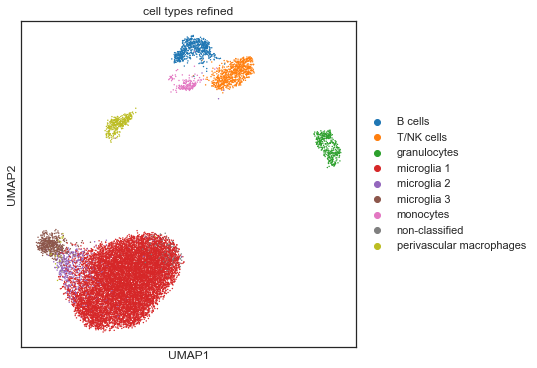

In [444]:
sc.pl.umap(adata_merge, color='cell types refined')

Add classifier info to both `adata_merge` and `adata_location`.

In [445]:
adata_merge.obs['cell types refined'][location_idx] = knn_classifier
adata_merge.obs['cell types refined'][adata_merge.obs['cell types refined']=='non-classified'] = 'microglia 1'

In [446]:
adata_merge.write(project_dir + 'data/' + 'adata_AD_WT_merged_with_location.h5ad')

In [447]:
adata_location.obs['cell types refined'] = knn_classifier
adata_location.obs['cell types refined'][adata_location.obs['cell types refined']=='non-classified'] = 'microglia 1'

<ipython-input-447-57ec8e746a60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_location.obs['cell types refined'][adata_location.obs['cell types refined']=='non-classified'] = 'microglia 1'


In [32]:
adata_merge = sc.read(project_dir + 'data/' + 'adata_AD_WT_merged_with_location.h5ad')

In [45]:
adata_merge.obs['cell types refined'] = adata_merge.obs['cell types refined'].cat.remove_unused_categories()

In [38]:
adata_merge

AnnData object with n_obs × n_vars = 14574 × 22860
    obs: 'Amp_batch_ID', 'batch', 'Mouse_ID', 'Seq_batch_ID', 'well_coordinates', 'plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'Spike_type', 'Number_of_cells', 'mouse_type', 'age', 'plate_id', 'location', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'louvain', 'cell types', 'louvain_R', 'cell types refined', 'microglia_sub', 'remove_non_classified'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'cell types refined_colors', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

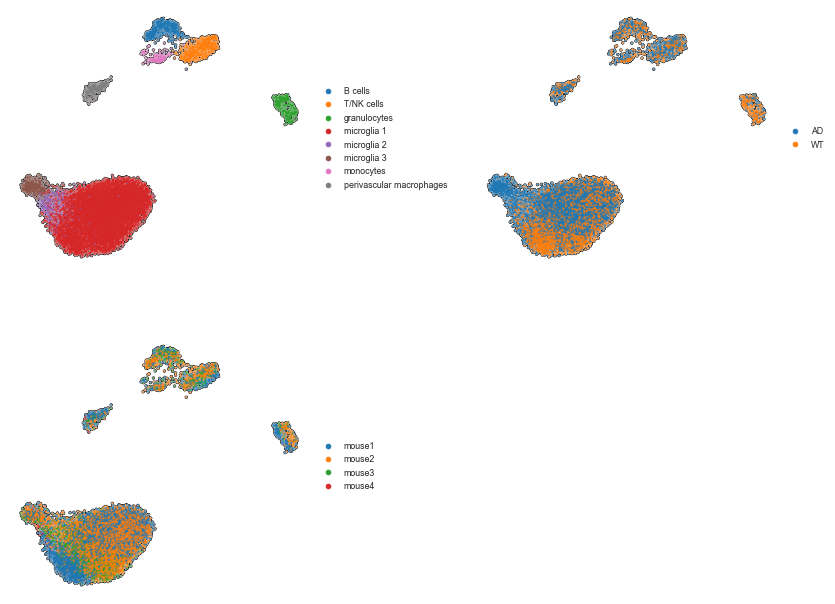

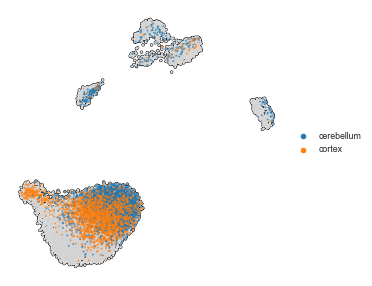

In [50]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_merge, color=['cell types refined', 
                               'mouse_type', 'replicate'], title=['', '','', ''], wspace=0.4, 
           frameon=False, ncols=2, size=15, add_outline=True,
           save = today + '_microglia.pdf'
          )
sc.pl.umap(adata_merge, color=['location', 
                              ], title=['', '','', ''], wspace=0.4, 
           groups=['cerebellum','cortex'],
           frameon=False, ncols=2, size=15, add_outline=True,
           save = today + '_microglia_loc.pdf'
          )

Let us plot the marker gene expression to show the identity of the cell populations.

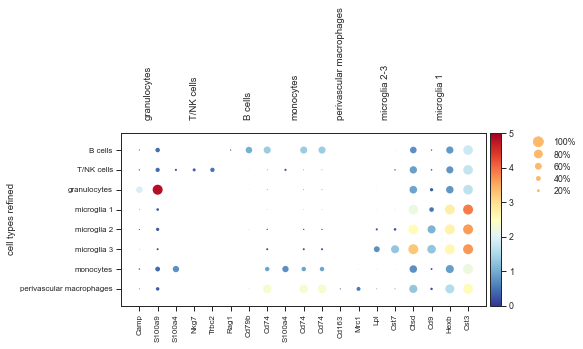

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[6.6499999999999995, 0, 0.2, 0.5, 0.25])

In [56]:
sc.pl.dotplot(adata_merge, groupby='cell types refined', var_names=marker_genes, 
              color_map='RdYlBu_r', vmax=5, vmin=0,
              save = today + '_marker_expression.pdf'
             )

In [449]:
tmp = adata_location.obs.groupby(['mouse_type', 'location', 'replicate',
                    'cell types refined'])['replicate'].count().unstack().fillna(0)
tmp = tmp.rename(columns=str).reset_index()

In [450]:
tmp.columns

Index(['mouse_type', 'location', 'replicate', 'B cells', 'T/NK cells',
       'granulocytes', 'microglia 1', 'microglia 2', 'microglia 3',
       'monocytes', 'perivascular macrophages'],
      dtype='object', name='cell types refined')

In [451]:
tmp = tmp.drop(['granulocytes', 'T/NK cells', 'B cells', 'monocytes',
                  'perivascular macrophages'], axis=1)

In [452]:
tmp

cell types refined,mouse_type,location,replicate,microglia 1,microglia 2,microglia 3
0,AD,cerebellum,mouse1,709,5,2
1,AD,cerebellum,mouse2,715,7,6
2,AD,cortex,mouse1,834,19,59
3,AD,cortex,mouse2,794,16,100
4,WT,cerebellum,mouse1,449,3,2
5,WT,cerebellum,mouse2,424,3,4
6,WT,cortex,mouse1,412,0,0
7,WT,cortex,mouse2,581,1,1


Save tmp table to file for testing with scCODA.

In [453]:
tmp.to_csv(project_dir + 'table/' + 'cell_count_microglia_AD_WT_location.csv')

In [4]:
tmp = pd.read_csv(project_dir + 'table/' + 'cell_count_microglia_AD_WT_location.csv', index_col=0)

In [5]:
tmp

,mouse_type,location,replicate,microglia 1,microglia 2,microglia 3
0,AD,cerebellum,mouse1,709,5,2
1,AD,cerebellum,mouse2,715,7,6
2,AD,cortex,mouse1,834,19,59
3,AD,cortex,mouse2,794,16,100
4,WT,cerebellum,mouse1,449,3,2
5,WT,cerebellum,mouse2,424,3,4
6,WT,cortex,mouse1,412,0,0
7,WT,cortex,mouse2,581,1,1


Get proportions.

In [6]:
tmp2 = tmp.loc[:, tmp.columns[3:]]

In [7]:
tmp2 = tmp2.div(tmp2.sum(axis=1), axis=0)

In [8]:
tmp2[['mouse_type', 'location', 'replicate']] = tmp[['mouse_type', 'location', 'replicate']]

In [9]:
tmp2

,microglia 1,microglia 2,microglia 3,mouse_type,location,replicate
0,0.990223,0.006983,0.002793,AD,cerebellum,mouse1
1,0.982143,0.009615,0.008242,AD,cerebellum,mouse2
2,0.914474,0.020833,0.064693,AD,cortex,mouse1
3,0.872527,0.017582,0.109890,AD,cortex,mouse2
4,0.988987,0.006608,0.004405,WT,cerebellum,mouse1
5,0.983759,0.006961,0.009281,WT,cerebellum,mouse2
6,1.000000,0.000000,0.000000,WT,cortex,mouse1
7,0.996569,0.001715,0.001715,WT,cortex,mouse2


microglia 1


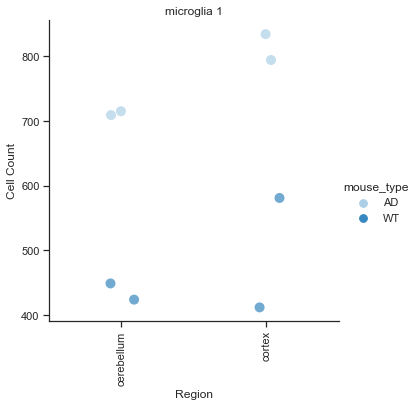

microglia 2


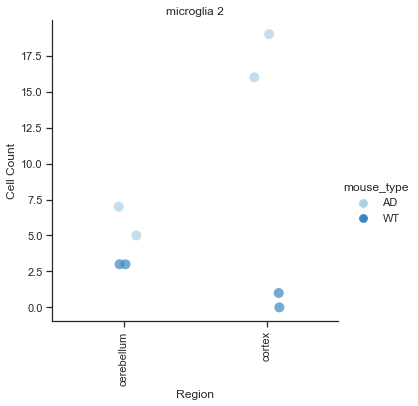

microglia 3


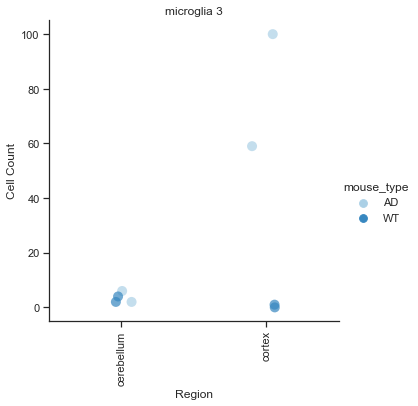

In [24]:
df = pd.melt(tmp, id_vars=['mouse_type', 'location'], value_vars=tmp.columns[3:])
df['cell types refined'] = df['variable'].astype('category')

df['mouse_type'] = df['mouse_type'].astype('category')
df['mouse_type'] = df['mouse_type'].cat.reorder_categories(['AD', 'WT'])

sb.set_context('notebook')
sb.set_style('ticks')

for cell_type in ['microglia 1', 'microglia 2','microglia 3']:
    print(cell_type)
    #fig, ax = pl.subplots(figsize=(5,5))
    df_tmp = df.loc[df['cell types refined']==cell_type]

    d = sb.catplot(x='location', y = 'value', hue="mouse_type", s=10, alpha=0.7,
               data= df_tmp, 
               #fliersize=1,
               palette='Blues')

    d.set(ylabel='Cell Count')
    loc, labels = pl.xticks()
    d.set_xticklabels(labels, rotation=90)
    d.set(xlabel='Region')
    d.set(title=cell_type)
    pl.show()

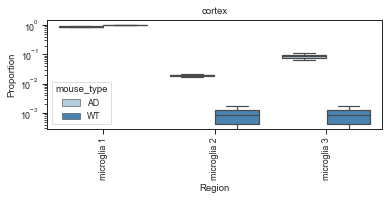

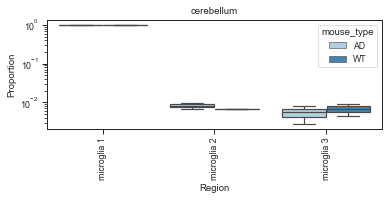

In [10]:
df = pd.melt(tmp2, id_vars=['mouse_type', 'location'], value_vars=tmp.columns[3:])
df['cell types refined'] = df['variable'].astype('category')

df['mouse_type'] = df['mouse_type'].astype('category')
df['mouse_type'] = df['mouse_type'].cat.reorder_categories(['AD', 'WT'])

sb.set_context('paper')
sb.set_style('ticks')

for region_type in enumerate(['cortex', 'cerebellum']):
    fig, ax = pl.subplots(figsize=(6,2))
    df_tmp = df.loc[df['location']==region_type[1]]

    d = sb.boxplot(x='cell types refined', y = 'value', hue=df_tmp["mouse_type"], 
               data= df_tmp, 
               fliersize=1,
               palette='Blues')

    d.set_ylabel('Proportion')
    loc, labels = pl.xticks()
    d.set_xticklabels(labels, rotation=90)
    d.set_xlabel('Region')
    d.set_yscale('log')
    d.set_title(region_type[1])
    pl.savefig('./figures/'+region_type[1] +'_boxplot_location.pdf', bbox_inches = 'tight')
    pl.show()
